### Выполнил студент МИВ-221: Айвар Уркунов

# Часть 2. Задача классификации Датасет: https://www.kaggle.com/competitions/titanic

Задачи: \
А. Решение задачи классификации
- Построить модель линейной классификации. При решении задачи методом градиентного спуска, необходимо вычислить градиент с помощью матрицы признаков.
- Построить модель на основе случайного леса классифицирующих деревьев. Определить параметры классификатора (количество деревьев, максимальная глубина дерева), при которых точность классификации максимальна.

Б. Анализ ROC/PR-кривых
- Рассмотреть простейшую задачу двухклассовой классификации, в которой элементы выборки имеют нормальное распределение с дисперсией 1 и средними значениями +𝝁 для экземпляров одного класса и -𝝁 для экземпляров другого класса. Экземпляры каждого класса появляются в обучающей выборке с вероятностью 1⁄2. Для данной задачи необходимо определить оптимальный классификатор, а также построить ROC-кривую для различных значений 𝝁.
- Для двух моделей, полученных в п.А., построить ROC и PR (precision-recall) кривые. Получить значения площадей под этими кривыми. Какая метрика (ROC-AUC или PR-AUC) является более предпочтительной в данном примере и почему?

In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [10]:
# ресерчим датасеты

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df = pd.read_csv('gender_submission.csv')

print(
    train_df.columns.tolist()
    , test_df.columns.tolist()
    , gender_submission_df.columns.tolist()
    , sep = '\n'
)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
['PassengerId', 'Survived']


In [5]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
gender_submission_df.dtypes

PassengerId    int64
Survived       int64
dtype: object

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
gender_submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [11]:
# обработка данных

In [12]:
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()
missing_values_train, missing_values_test

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64)

In [20]:
len(train_df)

891

- пропущенные значения Age можно заменить медианой
- пропущенных значений Cabin больше половины - уберем этот признак из анализа
- пропущенных значений Embarked 2, поэтому заменим их на наиболее часто встречающиеся значения в этом столбце
- в тестовом датасете 1 пропущенное значение Fare, можем заменить его медианой

In [21]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

mode_embarked = train_df['Embarked'].mode()[0]
train_df['Embarked'].fillna(mode_embarked, inplace=True)

test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

updated_missing_values_train = train_df.isnull().sum()
updated_missing_values_test = test_df.isnull().sum()

updated_missing_values_train, updated_missing_values_test

(PassengerId    0
 Survived       0
 Pclass         0
 Name           0
 Sex            0
 Age            0
 SibSp          0
 Parch          0
 Ticket         0
 Fare           0
 Embarked       0
 dtype: int64,
 PassengerId    0
 Pclass         0
 Name           0
 Sex            0
 Age            0
 SibSp          0
 Parch          0
 Ticket         0
 Fare           0
 Embarked       0
 dtype: int64)

Преобразуем категориальные переменные в числовой формат с использованием one-hot кодирования.

In [25]:
encoder = OneHotEncoder(sparse=False)

train_df_encoded = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])
test_df_encoded = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])

train_df_encoded.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,0,1


In [26]:
test_df_encoded.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,1,0,0,0,1


Реализуем нормализацию данных, это помогает ускорить сходимость алгоритма.
Она также включает масштабирование числовых признаков.

Также эмпирически выберем признаки для обучения. Удалим PassengerId, Name и Ticket.

In [30]:
features_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

X_train = train_df_encoded[features_list]
X_test = test_df_encoded[features_list]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:2], X_test_scaled[:2]

(array([[ 0.82737724, -0.5924806 ,  0.43279337, -0.47367361, -0.50244517,
         -0.73769513,  0.73769513, -0.48204268, -0.30756234,  0.61583843],
        [-1.56610693,  0.63878901,  0.43279337, -0.47367361,  0.78684529,
          1.35557354, -1.35557354,  2.0745051 , -0.30756234, -1.62380254]]),
 array([[ 0.82737724,  0.36944878, -0.4745452 , -0.47367361, -0.49078316,
         -0.73769513,  0.73769513, -0.48204268,  3.25137334, -1.62380254],
        [ 0.82737724,  1.33137817,  0.43279337, -0.47367361, -0.50747884,
          1.35557354, -1.35557354, -0.48204268, -0.30756234,  0.61583843]]))

## Решение задачи классификации

Построить модель линейной классификации. При решении задачи методом градиентного спуска, необходимо вычислить градиент с помощью матрицы признаков.

Применим метод логистической регрессии - стандартный метод для бинарной классификации

Обучим модель логичстической регрессии и предскажем данные на тестовой выборке
Также найдем коэффициенты модели

In [43]:
y_train = train_df_encoded['Survived']

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_test = log_reg.predict(X_test_scaled)
test_predictions = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_test
})

model_coefficients = log_reg.coef_

test_predictions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [41]:
print("Коэффициенты модели для каждого признака\n")
for i in range(len(model_coefficients[0])):
    print(f"{features_list[i]}: {model_coefficients[0][i]}")

Коэффициенты модели для каждого признака

Pclass: -0.9051900475750112
Age: -0.5045931686676068
SibSp: -0.35337600435996225
Parch: -0.07598292850118078
Fare: 0.10171728713707055
Sex_female: 0.6469179105636436
Sex_male: -0.6469179105636431
Embarked_C: 0.07783581691128076
Embarked_Q: 0.04452440986054131
Embarked_S: -0.09620662114091247


In [44]:
test_predictions.to_csv('test_predictions_task2.csv', index=False, sep=';')

### Реализуем логистическую регрессию с использованием градиентного спуска

In [81]:
class CustomLogisticRegression:
    """
    Реализация логистической регрессии с использованием градиентного спуска.
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def _sigmoid(self, x):
        """
        Метод для вычисления сигмоидной функции.
        """
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        """
        Обучение модели логистической регрессии с использованием градиентного спуска.
        """
        n_samples, n_features = X.shape

        # инициализируем параметры
        self.weights = np.zeros(n_features)
        self.bias = 0

        # градиентный спуск
        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(model)

            # Вычисление градиентов
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            # Обновление весов
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        """
        Предсказание вероятности принадлежности к классу.
        """
        model = np.dot(X, self.weights) + self.bias
        predictions = self._sigmoid(model)
        return predictions

    def predict(self, X, threshold=0.5):
        """
        Предсказание класса на основе заданного порога.
        """
        probabilities = self.predict_proba(X)
        return [1 if i > threshold else 0 for i in probabilities]

Сделаем и обучим разработанную модель логистической регрессии

In [82]:
custom_lr = CustomLogisticRegression()
custom_lr.fit(X_train_scaled, y_train)
y_pred_custom_lr = custom_lr.predict(X_test_scaled)
y_pred_custom_lr[:5]

[0, 1, 0, 0, 1]

# George, и тут нужно ли проверять?

## Решение задачи классификации

Построить модель на основе случайного леса классифицирующих деревьев. Определить параметры классификатора (количество деревьев, максимальная глубина дерева), при которых точность классификации максимальна.

Используем модель Random Forest - это ансамблевый метод машинного обучения, который работает путем построения множества решающих деревьев при обучении и выдачи класса, который является модой классов отдельных деревьев.
Для определения параметров классификатора используем метод поиска по сетке - Grid Search с кросс-валидацией.

In [47]:
random_forest = RandomForestClassifier()

# определение сетки параметров для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [5, 10, 15, None]   # Максимальная глубина дерева
}

# делаем Grid Search с кросс-валидацией
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# обучаем модель с использованием Grid Search
grid_search.fit(X_train_scaled, y_train)

# выводим лучшие параметры и достигнутую точность
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'max_depth': 10, 'n_estimators': 50}, 0.8260561170045821)

In [48]:
best_random_forest = grid_search.best_estimator_
y_pred_test_rf = best_random_forest.predict(X_test_scaled)

test_predictions_rf = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_test_rf
})

test_predictions_rf.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [49]:
test_predictions_rf.to_csv('test_predictions_rf.csv', index=False, sep=';')

In [56]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


# Джордж, как сравнить точность этих предсказаний? Только через сплит трейна на тест и трейн? или через джойн с gender submission

## Анализ ROC/PR-кривых

Рассмотреть простейшую задачу двухклассовой классификации, в которой элементы выборки имеют нормальное распределение с дисперсией 1 и средними значениями +𝝁 для экземпляров одного класса и -𝝁 для экземпляров другого класса. Экземпляры каждого класса появляются в обучающей выборке с вероятностью 1⁄2. Для данной задачи необходимо определить оптимальный классификатор, а также построить ROC-кривую для различных значений 𝝁.

Для анализа ROC-кривой с двухклассовой классификацией с нормально распределенными данными, мы можем использовать различные значения μ, чтобы увидеть, как изменение μ влияет на способность классификатора различать два класса. В данном контексте μ представляет собой степень разделения между двумя классами. Чем больше значение μ, тем больше разделение между классами. Выберу несколько значений для μ, чтобы увидеть различия в производительности классификатора. Значения μ в диапазоне от 0.5 до 3 с шагом 0.5.

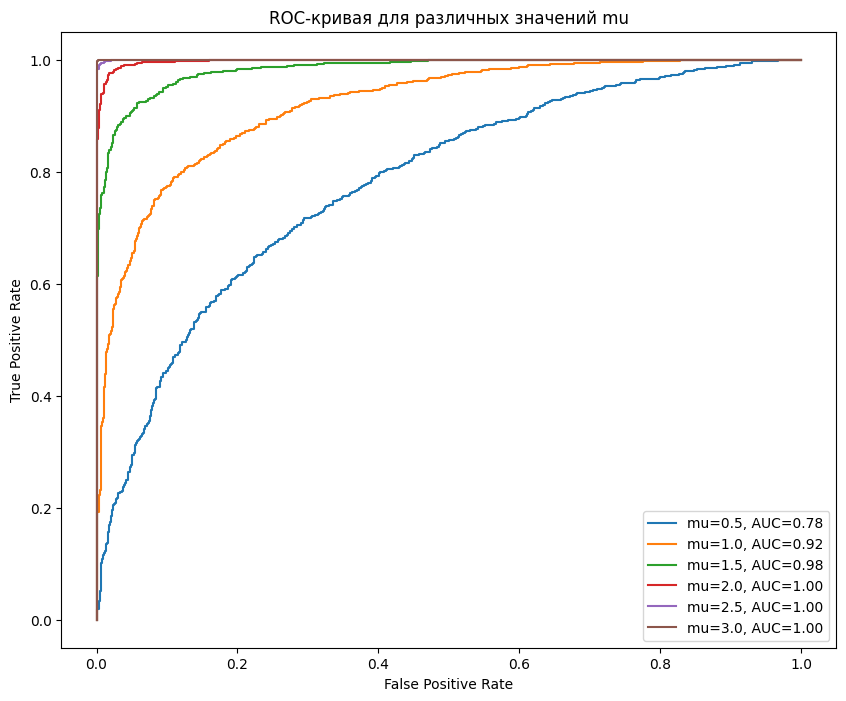

In [66]:
# для решения задачи сгенерируем синтетические данные, 
# тк, если корректно понял из задания, нужно решить эту задачу с использованием синтетических данных
def generate_data(mu, size=1000):
    class_1 = np.random.normal(mu, 1, size)
    class_2 = np.random.normal(-mu, 1, size)
    X = np.concatenate((class_1, class_2)).reshape(-1, 1)
    y = np.array([1] * size + [0] * size)
    return X, y

mu_values = np.arange(0.5, 3.5, 0.5)
roc_data = {}
for mu in mu_values:
    X, y = generate_data(mu)
    model = LogisticRegression()
    model.fit(X, y)

    y_scores = model.predict_proba(X)[:, 1]

    # вычисляем ROC-кривую и AUC
    fpr, tpr, _ = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data[mu] = (fpr, tpr, roc_auc)

# визуализация ROC-кривых для различных значений mu
plt.figure(figsize=(10, 8))
for mu, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'mu={mu}, AUC={roc_auc:.2f}')

plt.title('ROC-кривая для различных значений mu')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Таким образом, график показывает, что с увеличением μ улучшается производительность классификатора логистической регрессии, что видно по возрастанию AUC - меры эффективности классификатора. При меньших значениях μ классы более смешаны, ухудшая различение и снижая AUC. Это подчеркивает важность разделения классов в задачах классификации и использует ROC-кривые для оценки производительности классификаторов.

Выбор оптимального классификатора для задач с нормально распределенными классами основывается на максимизации различимости между классами. Лучший классификатор характеризуется наибольшей площадью под ROC-кривой (AUC), эффективно разделяет классы (особенно при большем разделении, обозначаемом μ), и подходит для линейно разделимых данных, как в случае с логистической регрессией. Логистическая регрессия оказалась оптимальной при высоком μ, обеспечивая высокую AUC. **Оптимальный классификатор может изменяться в зависимости от условий задачи, включая распределение данных и необходимые метрики эффективности.**

## Анализ ROC/PR-кривых

Для двух моделей, полученных в п.А., построить ROC и PR (precision-recall) кривые. Получить значения площадей под этими кривыми. Какая метрика (ROC-AUC или PR-AUC) является более предпочтительной в данном примере и почему?

In [70]:
y_scores_lr_titanic = log_reg.predict_proba(X_test_scaled)[:, 1]
y_scores_rf_titanic = best_random_forest.predict_proba(X_test_scaled)[:, 1]

y_true = gender_submission_df['Survived']

In [73]:
# расчитаем ROC-кривые и AUC для обеих моделей
fpr_lr_titanic, tpr_lr_titanic, _ = roc_curve(y_true, y_scores_lr_titanic)
roc_auc_lr_titanic = auc(fpr_lr_titanic, tpr_lr_titanic)

fpr_rf_titanic, tpr_rf_titanic, _ = roc_curve(y_true, y_scores_rf_titanic)
roc_auc_rf_titanic = auc(fpr_rf_titanic, tpr_rf_titanic)

# расчитаем PR-кривые и AUC для обеих моделей
precision_lr_titanic, recall_lr_titanic, _ = precision_recall_curve(y_true, y_scores_lr_titanic)
pr_auc_lr_titanic = auc(recall_lr_titanic, precision_lr_titanic)

precision_rf_titanic, recall_rf_titanic, _ = precision_recall_curve(y_true, y_scores_rf_titanic)
pr_auc_rf_titanic = auc(recall_rf_titanic, precision_rf_titanic)

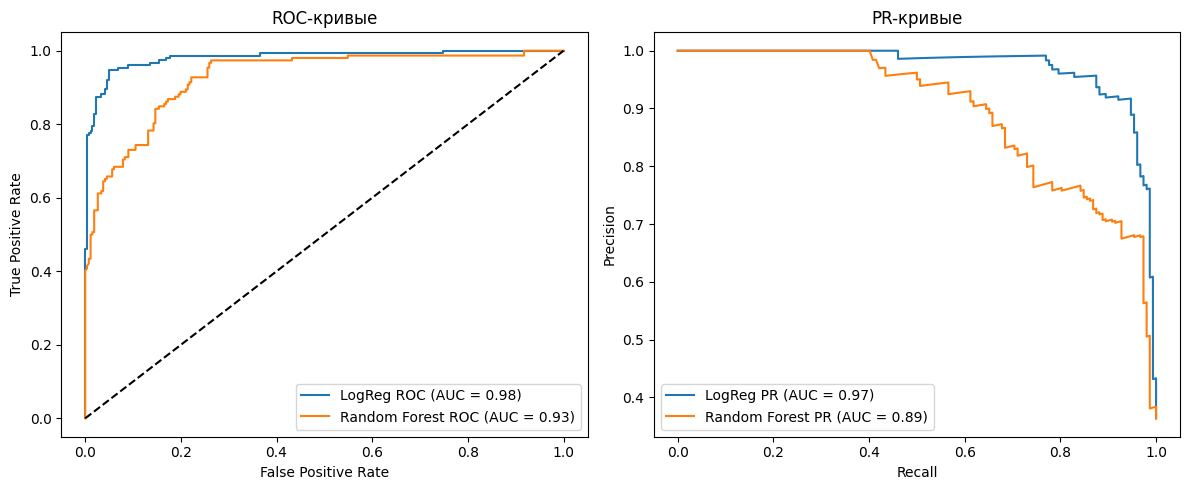

In [74]:
# построим ROC и PR кривых
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr_titanic, tpr_lr_titanic, label=f'LogReg ROC (AUC = {roc_auc_lr_titanic:.2f})')
plt.plot(fpr_rf_titanic, tpr_rf_titanic, label=f'Random Forest ROC (AUC = {roc_auc_rf_titanic:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-кривые')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_lr_titanic, precision_lr_titanic, label=f'LogReg PR (AUC = {pr_auc_lr_titanic:.2f})')
plt.plot(recall_rf_titanic, precision_rf_titanic, label=f'Random Forest PR (AUC = {pr_auc_rf_titanic:.2f})')
plt.title('PR-кривые')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
(roc_auc_lr_titanic, roc_auc_rf_titanic, pr_auc_lr_titanic, pr_auc_rf_titanic)

(0.9810793430945784,
 0.9271616541353382,
 0.9731148954842702,
 0.8949732913995481)

ROC-AUC часто используется, когда классы относительно сбалансированы, и важны оба типа ошибок — ложноположительные и ложноотрицательные.

PR-AUC более информативна в случаях, когда один из классов значительно меньше другого (несбалансированные классы) и когда нас в первую очередь интересует точность в предсказаниях положительного класса.

In [80]:
gender_submission_df['Survived'].value_counts()

0    266
1    152
Name: Survived, dtype: int64

Таким образом, в контексте данной задачи, классы не совсем сбалансированы, поэтому PR-AUC может предоставить более детальную информацию о способности модели предсказывать выживших. Однако, учитывая высокие значения как для ROC-AUC, так и для PR-AUC, обе метрики дают сильные доказательства эффективности обеих моделей.

# Вопрос Джорджу, это считается несбалансированными классами?